# FloPy

### Triangular mesh example

First set the path and import the required packages. The flopy path doesn't have to be set if you install flopy from a binary installer. If you want to run this notebook, you have to set the path to your own flopy path.

In [1]:
import os
import sys
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy
from flopy.utils.triangle import Triangle as Triangle

temp_dir = TemporaryDirectory()
workspace = temp_dir.name

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

3.10.5 (v3.10.5:f377153967, Jun  6 2022, 12:36:10) [Clang 13.0.0 (clang-1300.0.29.30)]
numpy version: 1.23.1
matplotlib version: 3.5.2
flopy version: 3.3.6


## Creating Meshes with the Triangle Class

The Flopy Triangle class at (flopy.utils.triangle.Triangle) can be used to generate triangular meshes using the Triangle program (https://www.cs.cmu.edu/~quake/triangle.html).  The Triangle class is a thin wrapper that builds input files for the Triangle program, reads Triangle output, and makes plots of the mesh.  To use the Triangle class, the user must have an executable copy of the triangle program somewhere on their system.

Let's start by making a simple triangular mesh of a circle using the Flopy Triangle class and the triangle program.

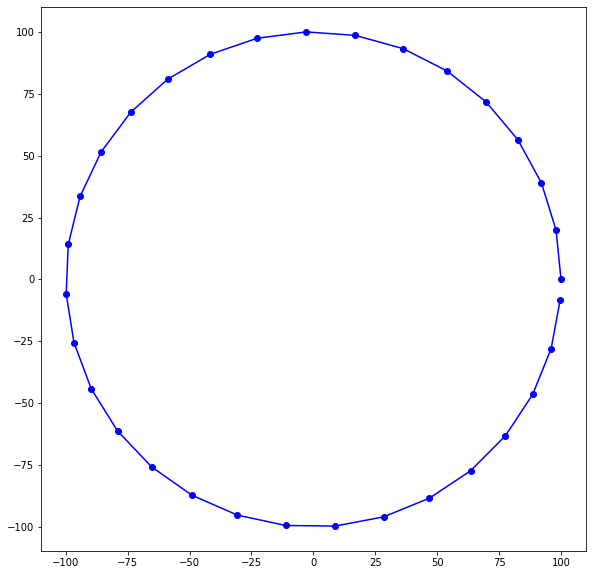

In [2]:
# we start by creating a polygon (circle_poly), which is a list of
# (x,y) points that define the circle
theta = np.arange(0.0, 2 * np.pi, 0.2)
radius = 100.0
x = radius * np.cos(theta)
y = radius * np.sin(theta)
circle_poly = [(x, y) for x, y in zip(x, y)]
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
ax.plot(x, y, "bo-");

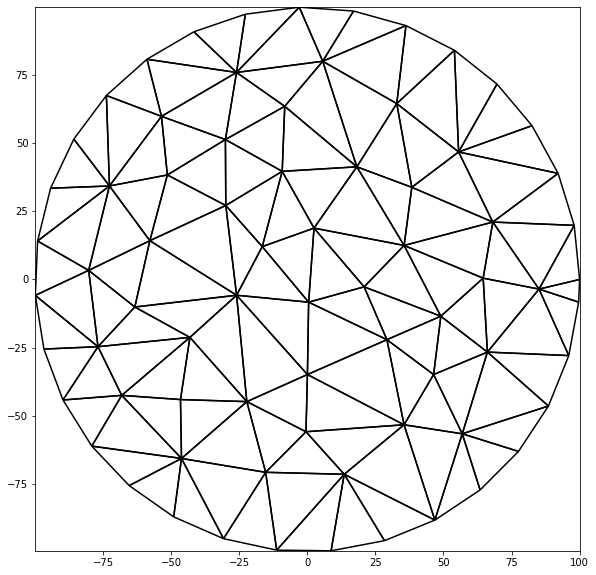

In [3]:
# We can then use the Triangle class and Triangle program
# to make the mesh, as follows.
tri = Triangle(maximum_area=500, angle=30, model_ws=workspace)
tri.add_polygon(circle_poly)
tri.build(verbose=False)
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
pc = tri.plot(ax=ax)

The Triangle class creates a .node and a .poly file as input for the Triangle program.  The Triangle class then reads four output files from the Triangle program into numpy structured arrays.  These four structured arrays are stored with the object as follows.

In [4]:
print(tri.node.dtype)
print(tri.ele.dtype)
print(tri.neigh.dtype)
print(tri.edge.dtype)

[('ivert', '<i8'), ('x', '<f8'), ('y', '<f8'), ('boundary_marker', '<i8')]
[('icell', '<i8'), ('iv1', '<i8'), ('iv2', '<i8'), ('iv3', '<i8')]
[('icell', '<i8'), ('neighbor1', '<i8'), ('neighbor2', '<i8'), ('neighbor3', '<i8')]
[('iedge', '<i8'), ('endpoint1', '<i8'), ('endpoint2', '<i8'), ('boundary_marker', '<i8')]


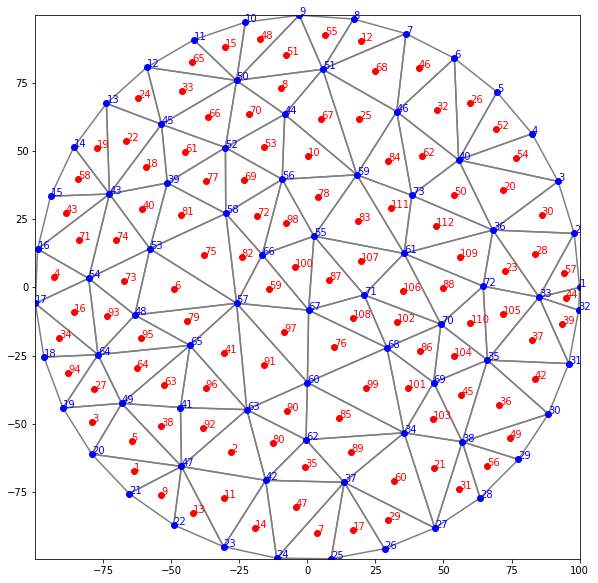

In [5]:
# We can also plot the cells and vertices and label them,
# but this really only works for coarse meshes
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
tri.plot(ax=ax, edgecolor="gray")
tri.plot_vertices(ax=ax, marker="o", color="blue")
tri.label_vertices(ax=ax, fontsize=10, color="blue")
tri.plot_centroids(ax=ax, marker="o", color="red")
tri.label_cells(ax=ax, fontsize=10, color="red")

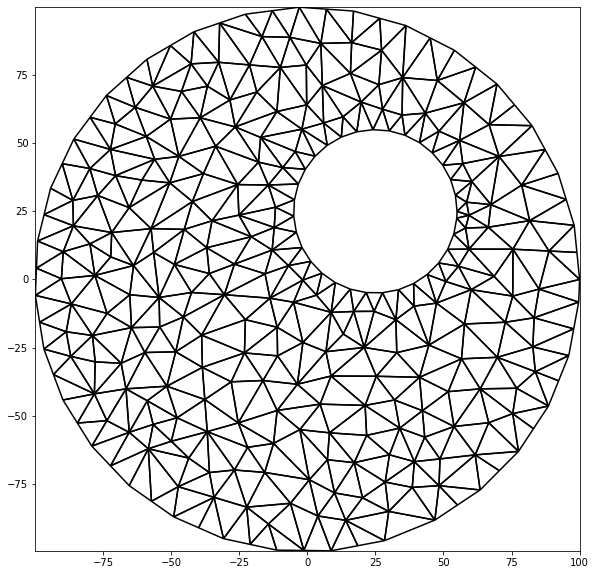

In [6]:
# What about a hole?
theta = np.arange(0.0, 2 * np.pi, 0.2)
radius = 30.0
x = radius * np.cos(theta) + 25.0
y = radius * np.sin(theta) + 25.0
inner_circle_poly = [(x, y) for x, y in zip(x, y)]

# The hole is created by passing in another polygon and
# then passing a point inside the hole polygon with the
# add_hole() method.
tri = Triangle(maximum_area=100, angle=30, model_ws=workspace)
tri.add_polygon(circle_poly)
tri.add_polygon(inner_circle_poly)
tri.add_hole((25, 25))
tri.build(verbose=False)
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
tri.plot(ax=ax);

## Specifying Regions with Different Triangle Sizes

Different parts of the domain can be assigned different levels of refinement by adding multiple polygons and then identifying the different polygons as regions with different maximum triangle areas.

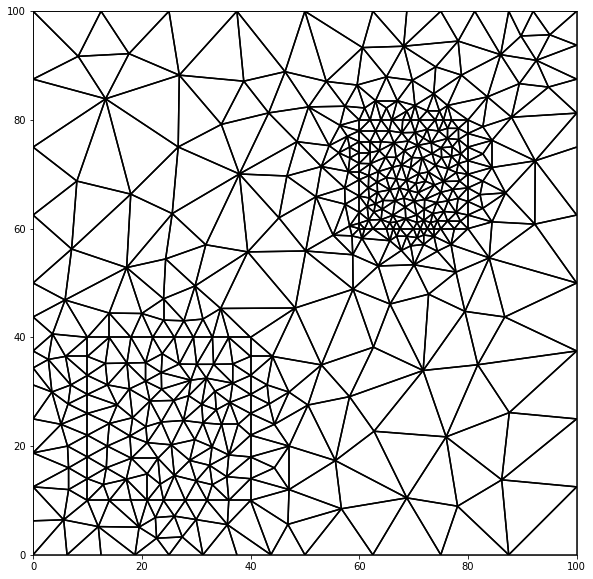

In [7]:
active_domain = [(0, 0), (100, 0), (100, 100), (0, 100)]
area1 = [(10, 10), (40, 10), (40, 40), (10, 40)]
area2 = [(60, 60), (80, 60), (80, 80), (60, 80)]
tri = Triangle(angle=30, model_ws=workspace)
tri.add_polygon(active_domain)
tri.add_polygon(area1)
tri.add_polygon(area2)
tri.add_region((1, 1), 0, maximum_area=100)  # point inside active domain
tri.add_region((11, 11), 1, maximum_area=10)  # point inside area1
tri.add_region((61, 61), 2, maximum_area=3)  # point inside area2
tri.build(verbose=False)
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
tri.plot(ax=ax);

## Identifying Boundary Cells

The Triangle class has some limited capabilities for identifying the cells on polygone boundaries.  In the example above, three polygons were added to the Triangle class.  An integer boundary marker is automatically calculated and assigned by the Triangle class.  Boundary marker 1 corresponds to the first line segment of the first polygon added. So in this case, boundary marker 1 corresponds to cells along the line `[(0, 0), (100, 0)]`.  Boundary marker 2 corresponds to the next line segment, which is along the right face of the domain.

Triangle has a method for getting back an integer array for the mesh that has a boundary marker id for each cell.  Values of zero indicate that the cell does not touch a boundary.

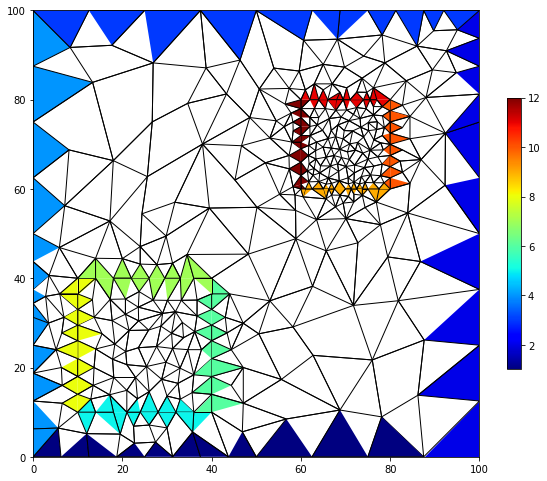

In [8]:
# this shows all the boundary cells
ibd = tri.get_boundary_marker_array()
ibd = np.ma.masked_equal(ibd, 0)
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
pc = tri.plot(a=ibd, cmap="jet")
plt.colorbar(pc, shrink=0.5);

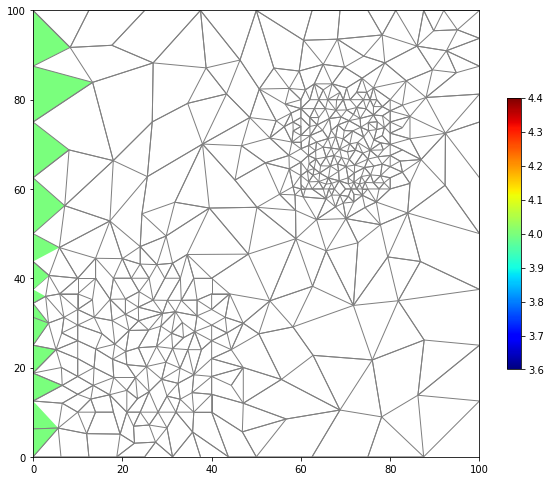

In [9]:
# we could plot just one group of boundary cells
# this shows all the boundary cells
ibd = tri.get_boundary_marker_array()
ibd = np.ma.masked_not_equal(ibd, 4)
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
pc = tri.plot(a=ibd, cmap="jet", edgecolor="gray")
cb = plt.colorbar(pc, shrink=0.5);

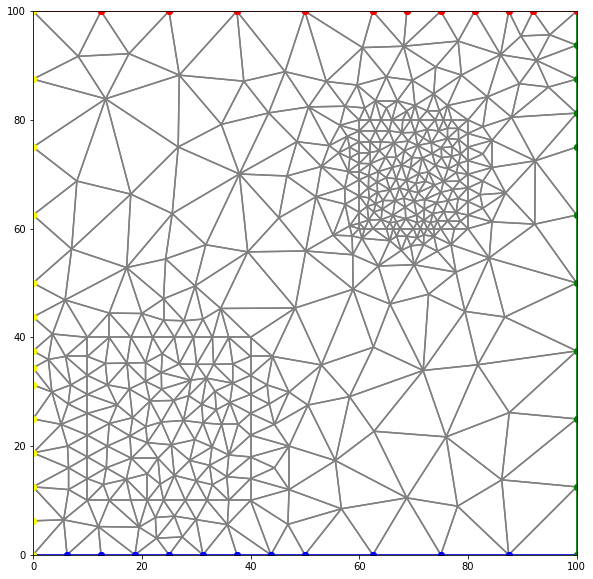

In [10]:
# we can also plot the lines that comprise the boundaries
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
tri.plot(ax=ax, edgecolor="gray")
for ibm in [1, 2, 3, 4]:
    colors = ["blue", "green", "red", "yellow"]
    tri.plot_boundary(ibm, ax, marker="o", color=colors[ibm - 1]);

## Cell Attributes

If regions (using the add_region() method) are used and an attribute value is provided, it is possible to determine the cells that are within each region.  


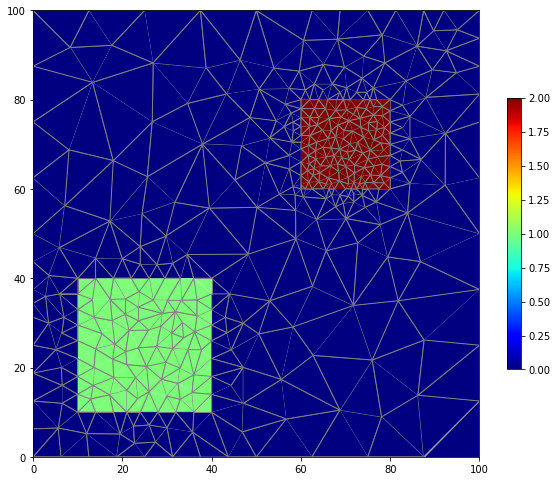

In [11]:
attribute_array = tri.get_attribute_array()
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
pc = tri.plot(a=attribute_array, cmap="jet", edgecolor="gray")
cb = plt.colorbar(pc, shrink=0.5);

## Building a Simple MODFLOW 6 Model

We can use the functionality described so far to build a simple MODFLOW 6 model using Flopy.  For demonstration purposes, we'll create a very coarse triangular mesh and impose constant head boundaries on the left and right sides.  We will simulate flow as steady state.

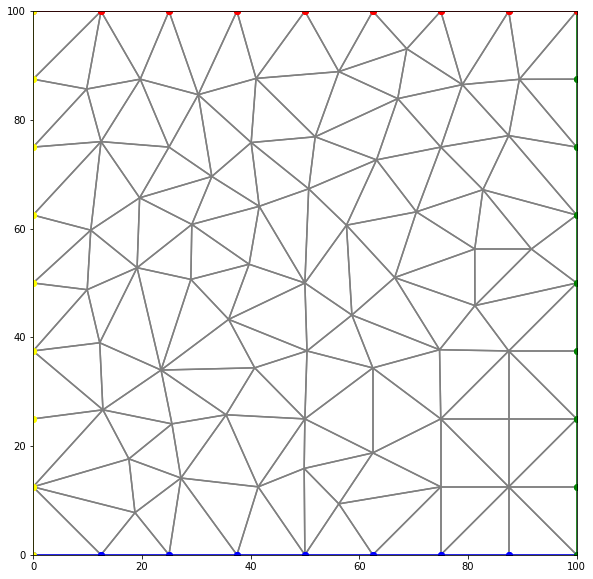

In [12]:
active_domain = [(0, 0), (100, 0), (100, 100), (0, 100)]
tri = Triangle(angle=30, maximum_area=100, model_ws=workspace)
tri.add_polygon(active_domain)
tri.build()
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
tri.plot(edgecolor="gray")
for ibm in [1, 2, 3, 4]:
    colors = ["blue", "green", "red", "yellow"]
    tri.plot_boundary(ibm, ax, marker="o", color=colors[ibm - 1]);

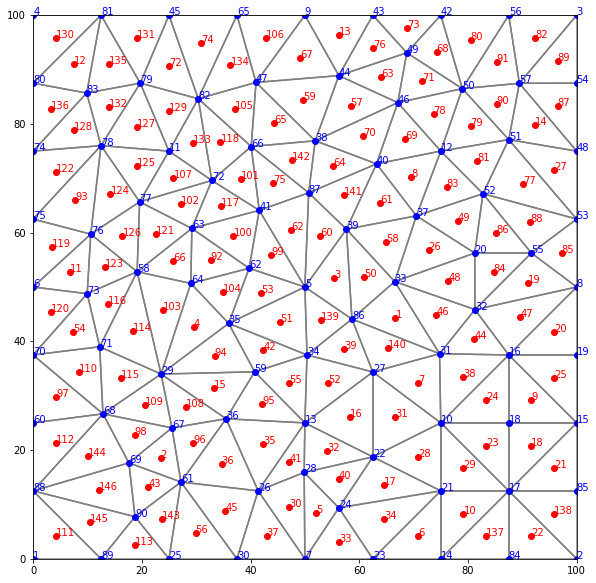

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
tri.plot(ax=ax, edgecolor="gray")
tri.plot_vertices(ax=ax, marker="o", color="blue")
tri.label_vertices(ax=ax, fontsize=10, color="blue")
tri.plot_centroids(ax=ax, marker="o", color="red")
tri.label_cells(ax=ax, fontsize=10, color="red");

In [14]:
name = "mf"
sim = flopy.mf6.MFSimulation(
    sim_name=name, version="mf6", exe_name="mf6", sim_ws=workspace
)
tdis = flopy.mf6.ModflowTdis(
    sim, time_units="DAYS", perioddata=[[1.0, 1, 1.0]]
)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
ims = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    complexity="complex",
    outer_hclose=1.0e-8,
    inner_hclose=1.0e-8,
)
cell2d = tri.get_cell2d()
vertices = tri.get_vertices()
xcyc = tri.get_xcyc()
nlay = 1
ncpl = tri.ncpl
nvert = tri.nvert
top = 1.0
botm = [0.0]
dis = flopy.mf6.ModflowGwfdisv(
    gwf,
    nlay=nlay,
    ncpl=ncpl,
    nvert=nvert,
    top=top,
    botm=botm,
    vertices=vertices,
    cell2d=cell2d,
)
npf = flopy.mf6.ModflowGwfnpf(
    gwf, xt3doptions=[(True)], save_specific_discharge=None
)
ic = flopy.mf6.ModflowGwfic(gwf)


def chdhead(x):
    return x * 10.0 / 100.0


chdlist = []
leftcells = tri.get_edge_cells(4)
rightcells = tri.get_edge_cells(2)
for icpl in leftcells + rightcells:
    h = chdhead(xcyc[icpl, 0])
    chdlist.append([(0, icpl), h])
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdlist)
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord="{}.cbc".format(name),
    head_filerecord="{}.hds".format(name),
    saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
)
sim.write_simulation()
success, buff = sim.run_simulation(report=True)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model mf...
    writing model name file...
    writing package disv...
    writing package npf...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 16 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: /Users/wes/dev/usgs-executables/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/04/2022

   MODFLOW 6 compiled Mar 07 2022 13:50:09 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been sub

 Using Simulation name file: mfsim.nam
 
    Solving:  Stress period:     1    Time step:     1
 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/07/30 16:18:21
 Elapsed run time:  0.086 Seconds
 

WARNING REPORT:

  1. NONLINEAR BLOCK VARIABLE 'OUTER_HCLOSE' IN FILE 'mf.ims' WAS DEPRECATED
     IN VERSION 6.1.1. SETTING OUTER_DVCLOSE TO OUTER_HCLOSE VALUE.
  2. LINEAR BLOCK VARIABLE 'INNER_HCLOSE' IN FILE 'mf.ims' WAS DEPRECATED IN
     VERSION 6.1.1. SETTING INNER_DVCLOSE TO INNER_HCLOSE VALUE.
 Normal termination of simulation.


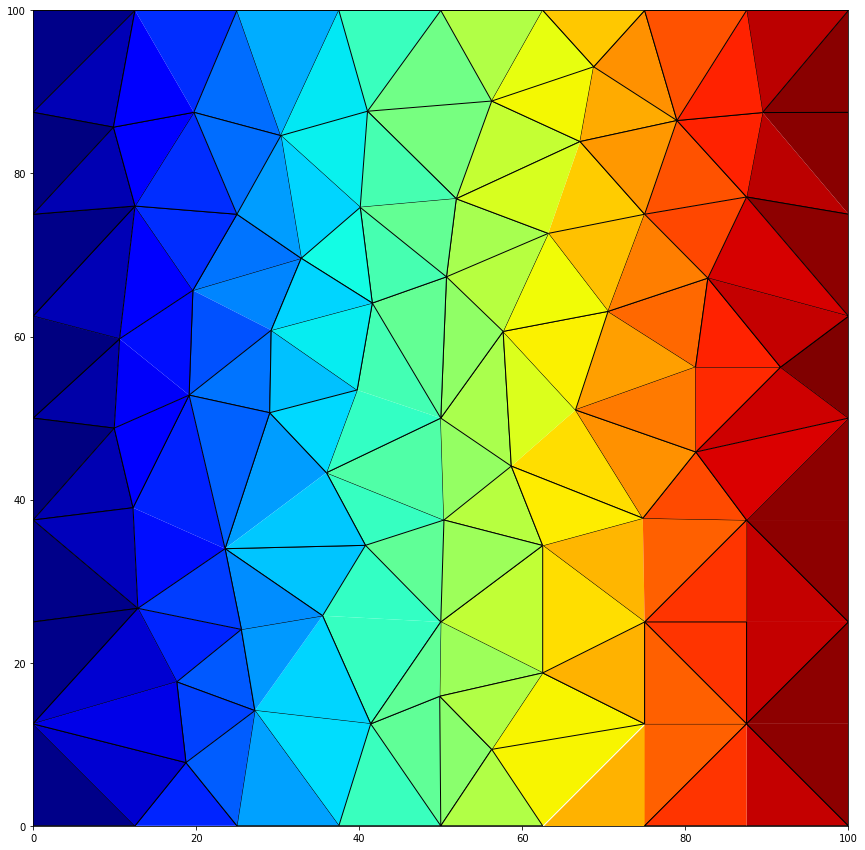

In [15]:
fname = os.path.join(workspace, name + ".hds")
hdobj = flopy.utils.HeadFile(fname, precision="double")
head = hdobj.get_data()
fname = os.path.join(workspace, name + ".cbc")
bdobj = flopy.utils.CellBudgetFile(fname, precision="double", verbose=False)
# qxqy = bdobj.get_data(text='DATA-SPDIS')[0]

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect="equal")
tri.plot(ax=ax, a=head[0, 0, :], cmap="jet");

In [16]:
try:
    # ignore PermissionError on Windows
    temp_dir.cleanup()
except:
    pass